**Table of contents**<a id='toc0_'></a>    
- [Implémentez un modèle de scoring](#toc1_)    
  - [Préparation des données et feature engineering](#toc1_1_)    
  - [Analyse exploratoire](#toc1_2_)    
    - [Structure des données](#toc1_2_1_)    
    - [Doublons](#toc1_2_2_)    
    - [Données manquantes](#toc1_2_3_)    
    - [Distribution de la variable cible](#toc1_2_4_)    
    - [Corrélations](#toc1_2_5_)    
  - [Modelisation](#toc1_3_)    
    - [Modèles Baseline](#toc1_3_1_)    
    - [LightGBM](#toc1_3_2_)    
      - [Modèle LightGBM par défaut](#toc1_3_2_1_)    
      - [Optimisation des hyperparamètres](#toc1_3_2_2_)    
      - [Optimisation du seuil](#toc1_3_2_3_)    
      - [Importance globale et locale des features](#toc1_3_2_4_)    
        - [Importance globale](#toc1_3_2_4_1_)    
        - [Importance locale](#toc1_3_2_4_2_)    
    - [Sauvegarde du modèle](#toc1_3_3_)    
    - [Test et Sauvegarde pour tester l'API](#toc1_3_4_)    
  - [Data Drift](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Implémentez un modèle de scoring](#toc0_)

In [ ]:
#%pip install pandas lightgbm scikit-learn matplotlib seaborn mlflow missingno imblearn shap evidently

In [ ]:
# Imports de librairies

# Librairies de base et gestion des données
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
import warnings

# Modélisation et évaluation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, cross_validate

# Prétraitement et Pipelines
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Outils d'optimisation et d'explicabilité
import shap

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Outils MLOps et Persistance
import joblib
import mlflow
import mlflow.sklearn

In [3]:
# Configuration
warnings.simplefilter(action='ignore', category=FutureWarning)
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

## <a id='toc1_1_'></a>[Préparation des données et feature engineering](#toc0_)

Notre modèle de scoring se base sur le kernel Kaggle "LightGBM with simple features", pour son approche de feature engineering.
Cependant, nous avons amélioré cette approche en intégrant toutes les étapes de traitement des données et de modélisation dans une pipeline complète.
Cette intégration a plusieurs avantages :
- Prévention du Data Leakage : En encapsulant les transformations, nous nous assurons que notre modèle n'est pas faussé par des informations provenant des données de test.
- Déploiement simplifié : La pipeline unifiée permet de déployer l'intégralité du modèle en une seule fois pour une API, évitant ainsi les erreurs de reproduction manuelle des étapes de prétraitement.
- Cohérence et reproductibilité : La pipeline garantit que chaque nouvelle donnée est traitée de la même manière, assurant la fiabilité des prédictions.

In [4]:
# Fonctions utilitaires
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f}s')

def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Utilisation de la mémoire du DataFrame au départ: {start_mem:.2f} Mo')
    
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
            
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Utilisation de la mémoire du DataFrame à la fin: {end_mem:.2f} Mo')
    print(f'Réduction de {100 * (start_mem - end_mem) / start_mem:.1f}%')
    return df

# Fonction pour le prétraitement et le feature engineering
from utils import preprocess_data


In [5]:
# Chargement et Préparation des Données
#--------------------------------------------------
with timer("Process application data"):
    df = pd.read_csv('application_train.csv')
    test_df = pd.read_csv('application_test.csv')
    
    df_combined = pd.concat([df, test_df], ignore_index=True)
    df_combined = df_combined[df_combined['CODE_GENDER'] != 'XNA'].reset_index(drop=True)
    df_combined = reduce_mem_usage(df_combined)

    
    train_df = df_combined[df_combined['TARGET'].notna()].copy().reset_index(drop=True)
    test_df = df_combined[df_combined['TARGET'].isna()].copy().reset_index(drop=True)
    
    train_df.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in train_df.columns]
    test_df.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in test_df.columns]
    
    train_df['TARGET'] = train_df['TARGET'].astype(int)

print("\nShape of training data:", train_df.shape)
print("Shape of testing data:", test_df.shape)
gc.collect()

Utilisation de la mémoire du DataFrame au départ: 331.59 Mo
Utilisation de la mémoire du DataFrame à la fin: 111.44 Mo
Réduction de 66.4%
[Process application data] done in 8s

Shape of training data: (307507, 122)
Shape of testing data: (48744, 122)


0

In [6]:
# Initialisation de MLflow
mlflow.set_experiment("Credit Scoring Model")
model_results = {}

In [7]:
# Afficher toutes les colonnes sans limite
pd.set_option('display.max_columns', None)

In [8]:
# Aperçu des données
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## <a id='toc1_2_'></a>[Analyse exploratoire](#toc0_)

### <a id='toc1_2_1_'></a>[Structure des données](#toc0_)

In [9]:
# Structure des données
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float32(65), int16(2), int32(2), int64(1), int8(36)
memory usage: 97.4 MB


Le jeu de données d'entraînement contient 307 507 lignes. Il est composé de 122 colonnes, incluant la variable cible (TARGET), l'identifiant des clients (SK_ID_CURR) et 120 variables explicatives.

### <a id='toc1_2_2_'></a>[Doublons](#toc0_)

In [10]:
# doublons
print("Nombre de doublons dans le jeu d'entrainement: {}".format(train_df.duplicated().sum()))
print("Nombre de doublons dans le jeu de test: {}".format(test_df.duplicated().sum()))

Nombre de doublons dans le jeu d'entrainement: 0
Nombre de doublons dans le jeu de test: 0


In [11]:
# doublons
print("Nombre IDs dupliqués dans le jeu d'entrainement dans le jeu d'entrainement: {}".format(train_df['SK_ID_CURR'].duplicated().sum()))
print("Nombre IDs dupliqués dans le jeu d'entrainements dans le jeu de test: {}".format(test_df['SK_ID_CURR'].duplicated().sum()))

Nombre IDs dupliqués dans le jeu d'entrainement dans le jeu d'entrainement: 0
Nombre IDs dupliqués dans le jeu d'entrainements dans le jeu de test: 0


### <a id='toc1_2_3_'></a>[Données manquantes](#toc0_)

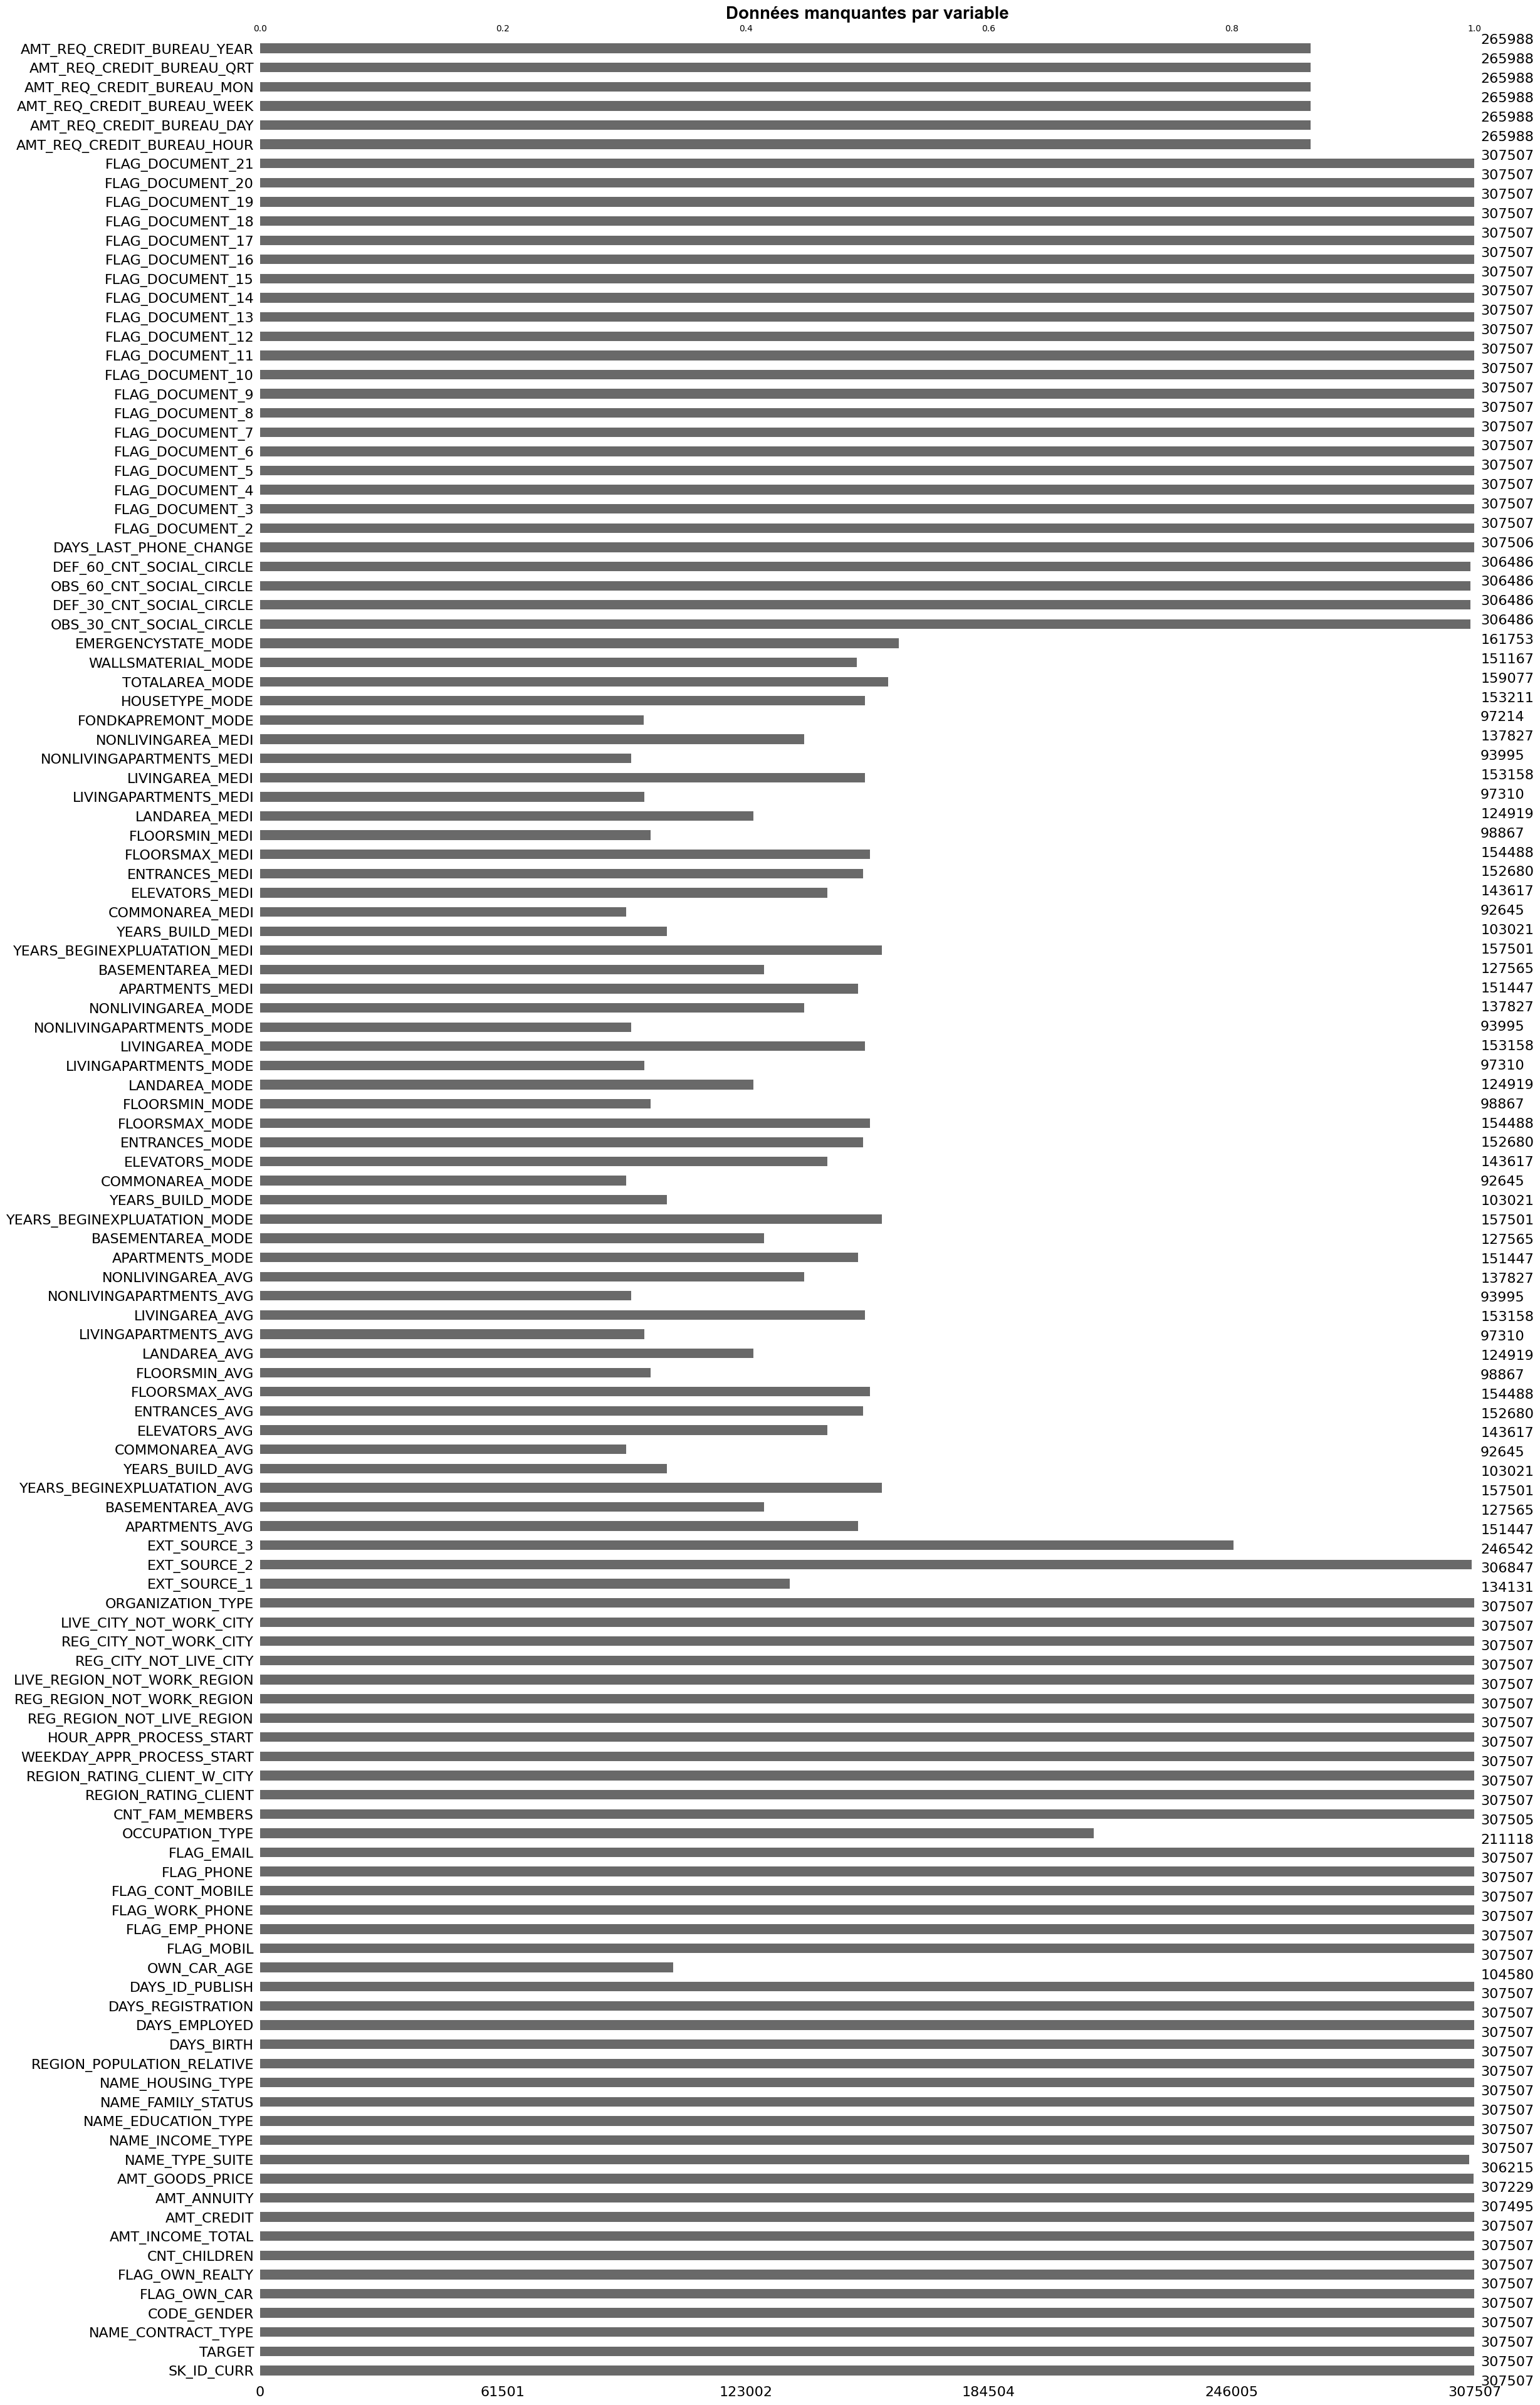

In [12]:
# Données manquantes dans le jeu de données d'entrainement 
plt.figure(figsize=(10, 6))
%matplotlib inline
msno.bar(train_df)
plt.title("Données manquantes par variable",fontname='Arial', fontsize=20, color='black', fontweight='bold')
plt.show()

In [13]:
# Variables avec des valeurs manquantes
print("Nombre de variables des données train avec des valeurs manquantes: {}".format((train_df.isna().mean()>0).sum()))
print("Nombre de variables des données test avec des valeurs manquantes: {}".format((test_df.isna().mean()>0).sum()))

Nombre de variables des données train avec des valeurs manquantes: 67
Nombre de variables des données test avec des valeurs manquantes: 65


67 variables sur 122 présentent des valeurs manquantes

In [14]:
# Variables avec 50% de leur valeurs qui sont manquantes
print("Nombre de variables des données train avec plus de 50 % de valeurs manquantes: {}".format((train_df.isna().mean()>0.5).sum()))
print("Nombre de variables des données test avec plus de 50 % de valeurs manquantes: {}".format((test_df.isna().mean()>0.5).sum()))

Nombre de variables des données train avec plus de 50 % de valeurs manquantes: 41
Nombre de variables des données test avec plus de 50 % de valeurs manquantes: 30


La nécessité de traiter les valeurs manquantes dépend de l'algorithme de machine learning que nous utiliserons. Les modèles basés sur les arbres, tels que LightGBM ou XGBoost, sont capables de gérer les données manquantes de manière native, ce qui rend l'imputation facultative.

### <a id='toc1_2_4_'></a>[Distribution de la variable cible](#toc0_)

In [15]:
counts=train_df["TARGET"].value_counts()
print(counts)

TARGET
0    282682
1     24825
Name: count, dtype: int64


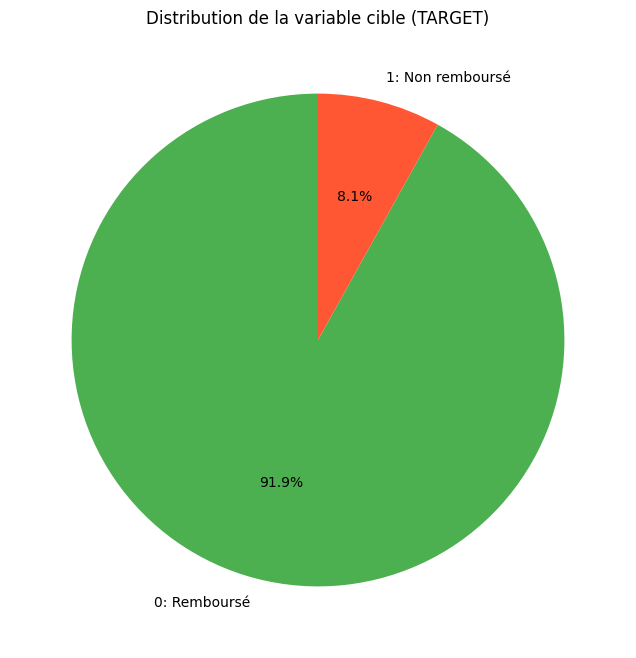

In [16]:
# Créer le diagramme circulaire
plt.figure(figsize=(8, 8)) 
plt.pie(counts, labels=['0: Remboursé', '1: Non remboursé'], autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF5733'])
plt.title('Distribution de la variable cible (TARGET)')
plt.show()

Le graphique illustre clairement que la classe 0 (remboursé) représente la très grande majorité des données, avec 91,9 % des observations. À l'inverse, la classe 1 (non remboursé) est une classe minoritaire, ne représentant que 8,1 % du jeu de données.
On constate donc un déséquilibre des classes qui présente un défi pour le machine learning car un modèle pourrait simplement prédire la classe majoritaire (0) pour chaque observation et obtenir un score de précision très élevé, tout en étant incapable de bien identifier les cas minoritaires qui sont souvent les plus importants à détecter.  
Pour traiter ce déséquilibre, il est crucial d'utiliser des techniques adaptées avant d'entraîner le modèle, comme :
- Techniques de suréchantillonnage (oversampling) : Dupliquer les observations de la classe minoritaire. Une méthode populaire est SMOTE (Synthetic Minority Over-sampling Technique), qui génère de nouvelles données pour la classe minoritaire.  
- Techniques de sous-échantillonnage (undersampling) : Réduire le nombre d'observations de la classe majoritaire.  
- Utilisation des hyperparamètres des modèles : De nombreux algorithmes, notamment les modèles d'arbres comme LightGBM et XGBoost, ou la Régression Logistique, intègrent des hyperparamètres qui permettent de gérer le poids des classes durant l'entraînement. L'avantage principal est que cette méthode agit directement sur la fonction de coût du modèle, ce qui le pousse à accorder plus d'importance aux erreurs de prédiction sur la classe minoritaire, sans modifier le jeu de données lui-même. C'est une approche plus native et souvent plus performante et c'est celle que nous choisissons pour traiter le desequilibre des classes de notre modèle

### <a id='toc1_2_5_'></a>[Corrélations](#toc0_)

In [17]:
# corrélations avec la target 
# Sélection des colonnes numériques pour le calcul de la corrélation
numerical_df = train_df.select_dtypes(include=np.number)

# Calcul des corrélations avec la cible ('TARGET')
correlations = numerical_df.corr()['TARGET'].dropna().sort_values()

# Affichage des corrélations les plus positives et les plus négatives
print('Corrélations les plus négatives:\n', correlations.head(10))
print('\nCorrélations les plus positives:\n', correlations.tail(10))

Corrélations les plus négatives:
 EXT_SOURCE_3                 -0.178926
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044934
FLOORSMAX_AVG                -0.044009
FLOORSMAX_MEDI               -0.043773
FLOORSMAX_MODE               -0.043231
AMT_GOODS_PRICE              -0.039647
REGION_POPULATION_RELATIVE   -0.037225
ELEVATORS_AVG                -0.034202
Name: TARGET, dtype: float64

Corrélations les plus positives:
 FLAG_DOCUMENT_3                0.044341
REG_CITY_NOT_LIVE_CITY         0.044394
FLAG_EMP_PHONE                 0.045984
REG_CITY_NOT_WORK_CITY         0.050992
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058901
REGION_RATING_CLIENT_W_CITY    0.060895
DAYS_BIRTH                     0.078242
TARGET                         1.000000
Name: TARGET, dtype: float64


On a affiché les corrélation les plus forte avec la target ( positivement et négativement), ces corrélations linéaires semblent assez faibles.    

la target est corrélée positivement avec l'âge des clients qui ici est exprimée en jours et enregistrée comme un nombre négatif par rapport à la date de la demande de prêt,  C'est pourquoi une corrélation positive avec cette variable signifie en réalité que les clients plus âgés (c'est-à-dire avec un nombre négatif plus faible, proche de zéro) sont associés à un risque plus faible de défaut de paiement.  

EXT_SOURCE_2 / 3 : Ce sont des scores provenant de sources externes. Un score plus élevé indique une meilleure fiabilité du client

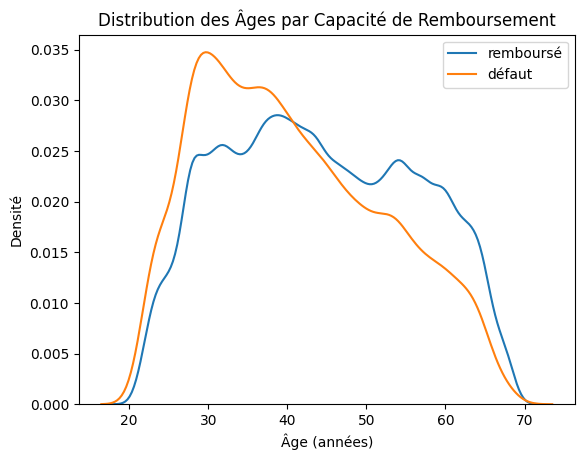

In [18]:
# Conversion de DAYS_BIRTH en âge en années directement
sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'remboursé')
sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'défaut')

# Ajouter les étiquettes et le titre
plt.xlabel('Âge (années)')
plt.ylabel('Densité')
plt.title('Distribution des Âges par Capacité de Remboursement')
plt.legend(loc='upper right')
plt.show()

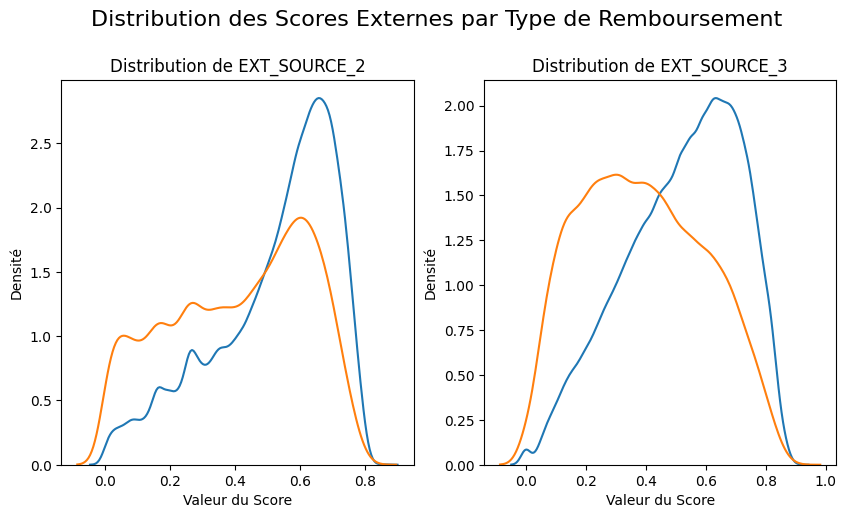

In [ ]:
# Liste des variables EXT_SOURCE à visualiser
ext_sources = ['EXT_SOURCE_2', 'EXT_SOURCE_3']

# Créer la figure et les sous-graphiques
plt.figure(figsize=(10, 5))
plt.suptitle('Distribution des Scores Externes par Type de Remboursement', y=1.02, fontsize=16)

# Boucle pour créer un graphique pour chaque variable
for i, source in enumerate(ext_sources):
    # Créer le sous-graphique à la position i+1 dans une grille de 1 ligne et 2 colonnes
    plt.subplot(1, 2, i + 1)
    
    # Tracer la distribution pour les clients qui ont remboursé (TARGET = 0)
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 0, source], label = 'Remboursé')
    
    # Tracer la distribution pour les clients qui ont fait défaut (TARGET = 1)
    sns.kdeplot(train_df.loc[train_df['TARGET'] == 1, source], label = 'Défaut')
    
    # Ajouter un titre et des étiquettes
    plt.title(f'Distribution de {source}')
    plt.xlabel('Valeur du Score')
    plt.ylabel('Densité')

    # Afficher la légende
    plt

Ces graphiques confirment que les variables EXT_SOURCE sont des indicateurs pertinents du risque de défaut, puisque des scores plus faibles sont systématiquement associés à un risque plus élevé.

## <a id='toc1_3_'></a>[Modelisation](#toc0_)

In [20]:
# train set / test set
X = train_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = train_df['TARGET']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [21]:
# Définition de la fonction de coût
def custom_cost(y_true, y_pred, cost_fp=1, cost_fn=10):
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    return total_cost

neg_cost_scorer = make_scorer(custom_cost, greater_is_better=False)

In [22]:
# Définition des Pipelines de prétraitement
# Création d'un transformateur pour le feature engineering manuel
preprocess_transformer = FunctionTransformer(preprocess_data, validate=False)

# ---- DÉFINIR LES LISTES DE FEATURES APRÈS LE FEATURE ENGINEERING ----
df_temp = preprocess_data(X_train.copy())
numerical_features = df_temp.select_dtypes(include=np.number).columns.tolist()
categorical_features = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
# ----------------------------------------------------------------------------------

numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

### <a id='toc1_3_1_'></a>[Modèles Baseline](#toc0_)

In [23]:
# DummyClassifier
print("--------------------------------------------------")
print("Évaluation du DummyClassifier")
with mlflow.start_run(run_name="DummyClassifier"):
    dummy_model = DummyClassifier(strategy="most_frequent")
    dummy_pipeline = Pipeline(steps=[
        ('feature_engineering', preprocess_transformer),
        ('preprocessor', preprocessor),
        ('classifier', dummy_model)
    ])
    
    dummy_pipeline.fit(X_train, y_train)
    
    # Prédictions sur le jeu de validation
    y_pred_proba_val = dummy_pipeline.predict_proba(X_val)[:, 1]
    y_pred_val = dummy_pipeline.predict(X_val)
    
    # Prédictions sur le jeu d'entraînement
    y_pred_proba_train = dummy_pipeline.predict_proba(X_train)[:, 1]
    y_pred_train = dummy_pipeline.predict(X_train)
    
    # Calcul des métriques de validation
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)

    # Calcul des métriques d'entraînement
    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)

    print(f"DummyClassifier - Score AUC (Train): {auc_score_train:.4f}")
    print(f"DummyClassifier - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"DummyClassifier - Coût métier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"DummyClassifier - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"DummyClassifier - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"DummyClassifier - Coût métier (Validation): {cost_score_val:.4f}")
    
    mlflow.log_param("model_name", "dummy_classifier")
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    
    model_results["Dummy Classifier"] = {
        "pipeline": dummy_pipeline, 
        "auc_train": auc_score_train, 
        "cost_train": cost_score_train, 
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=dummy_pipeline, artifact_path="dummy_classifier", registered_model_name="dummy_classifier")

--------------------------------------------------
Évaluation du DummyClassifier
DummyClassifier - Score AUC (Train): 0.5000
DummyClassifier - Accuracy (Train): 0.9193
DummyClassifier - Coût métier (Train): 198600.0000
---
DummyClassifier - Score AUC (Validation): 0.5000
DummyClassifier - Accuracy (Validation): 0.9193
DummyClassifier - Coût métier (Validation): 49650.0000


2025/09/14 19:31:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:31:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'dummy_classifier'.
2025/09/14 19:31:55 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: dummy_classifier, version 1
Created version '1' of model 'dummy_classifier'.


🏃 View run DummyClassifier at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/0327d64d8e0d484f96e227a1454b1701
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


In [24]:
# Regression logistique
print("--------------------------------------------------")
print("Évaluation de la Régression Logistique")
with mlflow.start_run(run_name="LogisticRegression"):
    lr_model = LogisticRegression(solver='liblinear', class_weight='balanced')
    lr_pipeline = Pipeline(steps=[
        ('feature_engineering', preprocess_transformer),
        ('preprocessor', preprocessor),
        ('classifier', lr_model)
    ])
    
    lr_pipeline.fit(X_train, y_train)
    
    # Prédictions sur le jeu de validation
    y_pred_proba_val = lr_pipeline.predict_proba(X_val)[:, 1]
    y_pred_val = lr_pipeline.predict(X_val)
    
    # Prédictions sur le jeu d'entraînement
    y_pred_proba_train = lr_pipeline.predict_proba(X_train)[:, 1]
    y_pred_train = lr_pipeline.predict(X_train)
    
    # Calcul des métriques de validation
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)
    
    # Calcul des métriques d'entraînement
    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    
    print(f"Logistic Regression - Score AUC (Train): {auc_score_train:.4f}")
    print(f"Logistic Regression - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"Logistic Regression - Coût métier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"Logistic Regression - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"Logistic Regression - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"Logistic Regression - Coût métier (Validation): {cost_score_val:.4f}")
    
    mlflow.log_param("model_name", "logistic_regression")
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    mlflow.log_param("prediction_threshold", 0.5)
    
    model_results["Logistic Regression"] = {
        "pipeline": lr_pipeline,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=lr_pipeline, artifact_path="logistic_regression", registered_model_name="logistic_regression")

--------------------------------------------------
Évaluation de la Régression Logistique
Logistic Regression - Score AUC (Train): 0.7501
Logistic Regression - Accuracy (Train): 0.6887
Logistic Regression - Coût métier (Train): 133487.0000
---
Logistic Regression - Score AUC (Validation): 0.7534
Logistic Regression - Accuracy (Validation): 0.6897
Logistic Regression - Coût métier (Validation): 33107.0000


2025/09/14 19:33:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:34:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'logistic_regression'.
2025/09/14 19:34:00 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: logistic_regression, version 1
Created version '1' of model 'logistic_regression'.


🏃 View run LogisticRegression at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/c110c79a3f33491e8c45498da9fed7b4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


### <a id='toc1_3_2_'></a>[LightGBM](#toc0_)

#### <a id='toc1_3_2_1_'></a>[Modèle LightGBM par défaut](#toc0_)

In [25]:
# Modèle LightGBM par défaut
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
scale_pos_weight = neg_count / pos_count

lgbm_model_default = lgb.LGBMClassifier(objective='binary', verbose=-1, random_state=0, n_jobs=-1, scale_pos_weight=scale_pos_weight)
lgbm_pipeline_default = ImbPipeline(steps=[
    ('feature_engineering', preprocess_transformer),
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model_default)
])

print("--------------------------------------------------")
print("Validation croisée du modèle LGBM par défaut")

cv_results = cross_validate(
    lgbm_pipeline_default,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    scoring={'roc_auc': 'roc_auc', 'neg_cost': neg_cost_scorer, 'accuracy': 'accuracy'},
    n_jobs=-1
)

auc_cv = np.mean(cv_results['test_roc_auc'])
cost_cv = -np.mean(cv_results['test_neg_cost'])
accuracy_cv = np.mean(cv_results['test_accuracy'])

print(f"LGBM - Score AUC moyen (CV): {auc_cv:.4f}")
print(f"LGBM - Accuracy moyenne (CV): {accuracy_cv:.4f}")
print(f"LGBM - Coût métier moyen (CV): {cost_cv:.4f}")

--------------------------------------------------
Validation croisée du modèle LGBM par défaut
LGBM - Score AUC moyen (CV): 0.7613
LGBM - Accuracy moyenne (CV): 0.7071
LGBM - Coût métier moyen (CV): 32482.0000


In [26]:
# Validation finale avec enregistrement MLflow
print("--------------------------------------------------")
print("Évaluation et enregistrement du modèle LGBM par défaut")
with mlflow.start_run(run_name="LGBM_Default"):
    # Entraînement sur le jeu d'entraînement complet
    lgbm_pipeline_default.fit(X_train, y_train)

    # Prédictions sur le jeu de validation
    y_pred_proba_val = lgbm_pipeline_default.predict_proba(X_val)[:, 1]
    y_pred_val = lgbm_pipeline_default.predict(X_val)

    # Prédictions sur le jeu d'entraînement
    y_pred_proba_train = lgbm_pipeline_default.predict_proba(X_train)[:, 1]
    y_pred_train = lgbm_pipeline_default.predict(X_train)

    # Calcul des métriques
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)

    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)

    print(f"LGBM - Score AUC (Train): {auc_score_train:.4f}")
    print(f"LGBM - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"LGBM - Coût métier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"LGBM - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"LGBM - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"LGBM - Coût métier (Validation): {cost_score_val:.4f}")

    # Récupération et préfixage des paramètres désirés pour l'enregistrement MLflow
    default_params = lgbm_pipeline_default.named_steps['classifier'].get_params()
    desired_params = {
        'classifier__learning_rate': default_params['learning_rate'],
        'classifier__num_leaves': default_params['num_leaves'],
        'classifier__n_estimators': default_params['n_estimators']
    }
    
    # Enregistrement dans MLflow
    mlflow.log_param("model_name", "lgbm_default")
    mlflow.log_params(desired_params)
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    mlflow.log_param("prediction_threshold", 0.5)

    model_results["LGBM Default"] = {
        "pipeline": lgbm_pipeline_default,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=lgbm_pipeline_default, artifact_path="lgbm_default", registered_model_name="lgbm_default")

--------------------------------------------------
Évaluation et enregistrement du modèle LGBM par défaut


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM - Score AUC (Train): 0.8030
LGBM - Accuracy (Train): 0.7116
LGBM - Coût métier (Train): 117365.0000
---
LGBM - Score AUC (Validation): 0.7680
LGBM - Accuracy (Validation): 0.7056
LGBM - Coût métier (Validation): 31500.0000


2025/09/14 19:35:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:35:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'lgbm_default'.
2025/09/14 19:35:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm_default, version 1
Created version '1' of model 'lgbm_default'.


🏃 View run LGBM_Default at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/4f280103a95543a58ce0a0886fc386e6
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


#### <a id='toc1_3_2_2_'></a>[Optimisation des hyperparamètres](#toc0_)

In [27]:
# Définition des paramètres pour la recherche par grille
param_grid = {
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__num_leaves': [20, 31, 40],
    'classifier__n_estimators': [100, 300, 700]
}

# Modèle LightGBM
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
scale_pos_weight = neg_count / pos_count

lgbm_model_tuned = lgb.LGBMClassifier(
    objective='binary', verbose=-1, random_state=0, n_jobs=-1, scale_pos_weight=scale_pos_weight
)

# Création de la pipeline pour l'optimisation
lgbm_pipeline_tuned = ImbPipeline(steps=[
    ('feature_engineering', preprocess_transformer),
    ('preprocessor', preprocessor),
    ('classifier', lgbm_model_tuned)
])

print("--------------------------------------------------")
print("Optimisation des hyperparamètres avec GridSearchCV")

grid_search = GridSearchCV(
    estimator=lgbm_pipeline_tuned,
    param_grid=param_grid,
    scoring=neg_cost_scorer,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=0),
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cost_cv = -grid_search.best_score_

print("\nMeilleurs paramètres trouvés :", best_params)
print(f"Meilleur coût métier moyen (CV) : {best_cost_cv:.4f}")

--------------------------------------------------
Optimisation des hyperparamètres avec GridSearchCV
Fitting 4 folds for each of 27 candidates, totalling 108 fits

Meilleurs paramètres trouvés : {'classifier__learning_rate': 0.05, 'classifier__n_estimators': 300, 'classifier__num_leaves': 31}
Meilleur coût métier moyen (CV) : 32308.5000


In [28]:
print("--------------------------------------------------")
print("Évaluation et enregistrement du meilleur modèle LGBM")
with mlflow.start_run(run_name="LGBM_Optimized"):
    # Le meilleur estimateur est la pipeline complète déjà entraînée par GridSearchCV
    final_lgbm_model = grid_search.best_estimator_

    # Prédictions sur le jeu de validation
    y_pred_proba_val = final_lgbm_model.predict_proba(X_val)[:, 1]
    y_pred_val = final_lgbm_model.predict(X_val)

    # Prédictions sur le jeu d'entraînement
    y_pred_proba_train = final_lgbm_model.predict_proba(X_train)[:, 1]
    y_pred_train = final_lgbm_model.predict(X_train)
    
    # Calcul des métriques
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val)
    accuracy_score_val = accuracy_score(y_val, y_pred_val)

    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train)
    accuracy_score_train = accuracy_score(y_train, y_pred_train)

    print(f"LGBM Optimisé - Score AUC (Train): {auc_score_train:.4f}")
    print(f"LGBM Optimisé - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"LGBM Optimisé - Coût métier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"LGBM Optimisé - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"LGBM Optimisé - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"LGBM Optimisé - Coût métier (Validation): {cost_score_val:.4f}")
    
    # Enregistrement dans MLflow
    mlflow.log_params(best_params)
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    mlflow.log_param("prediction_threshold", 0.5)
    
    model_results["LGBM Optimized"] = {
        "pipeline": final_lgbm_model,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    mlflow.sklearn.log_model(sk_model=final_lgbm_model, artifact_path="lgbm_optimized", registered_model_name="lgbm_optimized")

--------------------------------------------------
Évaluation et enregistrement du meilleur modèle LGBM


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM Optimisé - Score AUC (Train): 0.8203
LGBM Optimisé - Accuracy (Train): 0.7248
LGBM Optimisé - Coût métier (Train): 111287.0000
---
LGBM Optimisé - Score AUC (Validation): 0.7686
LGBM Optimisé - Accuracy (Validation): 0.7150
LGBM Optimisé - Coût métier (Validation): 31386.0000


2025/09/14 19:59:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:59:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'lgbm_optimized'.
2025/09/14 19:59:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: lgbm_optimized, version 1
Created version '1' of model 'lgbm_optimized'.


🏃 View run LGBM_Optimized at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/695f36c17b0a446b93f366ad785be7a8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


#### <a id='toc1_3_2_3_'></a>[Optimisation du seuil](#toc0_)

c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--------------------------------------------------
Meilleur seuil de prédiction sur le jeu de validation: 0.52
Métriques pour le seuil optimal:
Val AUC: 0.7686
Val Accuracy: 0.7371
Val Cost: 31073


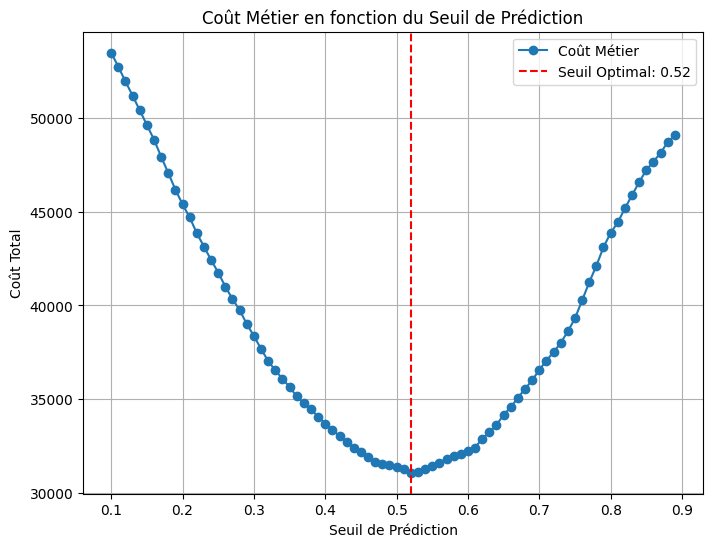

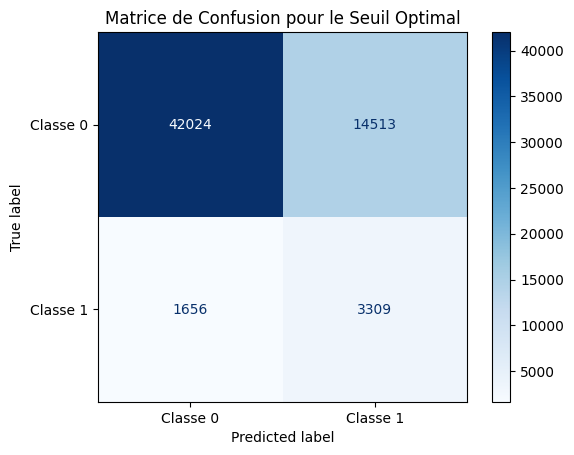

In [29]:
# Récupérer le meilleur modèle après l'optimisation des hyperparamètres
final_lgbm_model = grid_search.best_estimator_
y_val_proba = final_lgbm_model.predict_proba(X_val)[:, 1]

# Optimisation du seuil de prédiction sur le jeu de validation
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
min_cost = float('inf')
costs_list = []

for threshold in thresholds:
    y_val_pred = (y_val_proba >= threshold).astype(int)
    current_cost = custom_cost(y_val, y_val_pred)
    costs_list.append(current_cost)

    if current_cost < min_cost:
        min_cost = current_cost
        best_threshold = threshold

y_val_pred_optimal = (y_val_proba >= best_threshold).astype(int)

# Calcul des métriques pour le seuil optimal
auc_optimal_val = roc_auc_score(y_val, y_val_proba)
accuracy_optimal_val = accuracy_score(y_val, y_val_pred_optimal)
cost_optimal_val = custom_cost(y_val, y_val_pred_optimal)

print("--------------------------------------------------")
print(f"Meilleur seuil de prédiction sur le jeu de validation: {best_threshold:.2f}")
print("Métriques pour le seuil optimal:")
print(f"Val AUC: {auc_optimal_val:.4f}")
print(f"Val Accuracy: {accuracy_optimal_val:.4f}")
print(f"Val Cost: {cost_optimal_val}")

# Affichage du coût en fonction du seuil
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(thresholds, costs_list, marker='o', linestyle='-', label="Coût Métier")
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f"Seuil Optimal: {best_threshold:.2f}")
plt.title("Coût Métier en fonction du Seuil de Prédiction")
plt.xlabel("Seuil de Prédiction")
plt.ylabel("Coût Total")
plt.legend()
plt.grid(True)
plt.show()

# Affichage de la matrice de confusion pour le seuil optimal
cm = confusion_matrix(y_val, y_val_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0', 'Classe 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de Confusion pour le Seuil Optimal")
plt.show()

In [30]:
# Évaluation et enregistrement du meilleur modèle LGBM avec le seuil optimal
print("--------------------------------------------------")
print("Enregistrement du modèle LGBM optimisé avec le seuil optimal")
with mlflow.start_run(run_name="LGBM_Final_Model"):
    # Le meilleur estimateur est la pipeline complète déjà entraînée par GridSearchCV
    final_lgbm_model = grid_search.best_estimator_

    # Prédictions sur le jeu de validation
    y_pred_proba_val = final_lgbm_model.predict_proba(X_val)[:, 1]
    
    # Calcul des prédictions binaires avec le seuil optimal
    # Assurez-vous que la variable `best_threshold` est disponible à partir du code précédent
    y_pred_val_optimal = (y_pred_proba_val >= best_threshold).astype(int)

    # Prédictions sur le jeu d'entraînement
    y_pred_proba_train = final_lgbm_model.predict_proba(X_train)[:, 1]
    y_pred_train_optimal = (y_pred_proba_train >= best_threshold).astype(int)
    
    # Calcul des métriques avec le seuil optimal
    auc_score_val = roc_auc_score(y_val, y_pred_proba_val)
    cost_score_val = custom_cost(y_val, y_pred_val_optimal)
    accuracy_score_val = accuracy_score(y_val, y_pred_val_optimal)

    auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
    cost_score_train = custom_cost(y_train, y_pred_train_optimal)
    accuracy_score_train = accuracy_score(y_train, y_pred_train_optimal)

    print(f"LGBM Optimisé - Score AUC (Train): {auc_score_train:.4f}")
    print(f"LGBM Optimisé - Accuracy (Train): {accuracy_score_train:.4f}")
    print(f"LGBM Optimisé - Coût métier (Train): {cost_score_train:.4f}")
    print("---")
    print(f"LGBM Optimisé - Score AUC (Validation): {auc_score_val:.4f}")
    print(f"LGBM Optimisé - Accuracy (Validation): {accuracy_score_val:.4f}")
    print(f"LGBM Optimisé - Coût métier (Validation): {cost_score_val:.4f}")
    
    # Enregistrement dans MLflow
    # Les paramètres de l'optimisation GridSearchCV sont enregistrés
    mlflow.log_params(best_params)
    
    mlflow.log_metric("train_auc", auc_score_train)
    mlflow.log_metric("train_cost", cost_score_train)
    mlflow.log_metric("train_accuracy", accuracy_score_train)
    mlflow.log_metric("val_auc", auc_score_val)
    # Les métriques de validation sont enregistrées avec le seuil optimal
    mlflow.log_metric("val_cost", cost_score_val)
    mlflow.log_metric("val_accuracy", accuracy_score_val)
    # Le seuil optimal est enregistré en tant que paramètre
    mlflow.log_param("prediction_threshold", round(best_threshold,2))
    
    model_results["LGBM Optimized"] = {
        "pipeline": final_lgbm_model,
        "auc_train": auc_score_train,
        "cost_train": cost_score_train,
        "accuracy_train": accuracy_score_train,
        "auc_val": auc_score_val,
        "cost_val": cost_score_val,
        "accuracy_val": accuracy_score_val
    }
    # Enregistrement du modèle avec le nom qui reflète l'optimisation
    mlflow.sklearn.log_model(sk_model=final_lgbm_model, artifact_path="LGBM_Final_Model", registered_model_name="LGBM_Final_Model")

--------------------------------------------------
Enregistrement du modèle LGBM optimisé avec le seuil optimal


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGBM Optimisé - Score AUC (Train): 0.8203
LGBM Optimisé - Accuracy (Train): 0.7448
LGBM Optimisé - Coût métier (Train): 111626.0000
---
LGBM Optimisé - Score AUC (Validation): 0.7686
LGBM Optimisé - Accuracy (Validation): 0.7371
LGBM Optimisé - Coût métier (Validation): 31073.0000


2025/09/14 19:59:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/14 19:59:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LGBM_Final_Model'.
2025/09/14 19:59:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM_Final_Model, version 1
Created version '1' of model 'LGBM_Final_Model'.


🏃 View run LGBM_Final_Model at: http://127.0.0.1:5000/#/experiments/474524093679376131/runs/0ac67f691dc542c681d4e9bda3e1f24e
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/474524093679376131


#### <a id='toc1_3_2_4_'></a>[Importance globale et locale des features](#toc0_)

Le SHAP (SHapley Additive exPlanations) est un outil puissant qui nous permet d'expliquer les prédictions de notre modèle de deux manières. D'abord, il nous offre une vue globale en montrant l'importance de chaque variable sur l'ensemble du modèle. Ensuite, il fournit des explications locales pour une prédiction spécifique, ce qui nous permet de comprendre pourquoi le modèle a fait un choix particulier pour un individu donné

##### <a id='toc1_3_2_4_1_'></a>[Importance globale](#toc0_)

c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


--- Création du SHAP Summary Plot (dot plot) ---


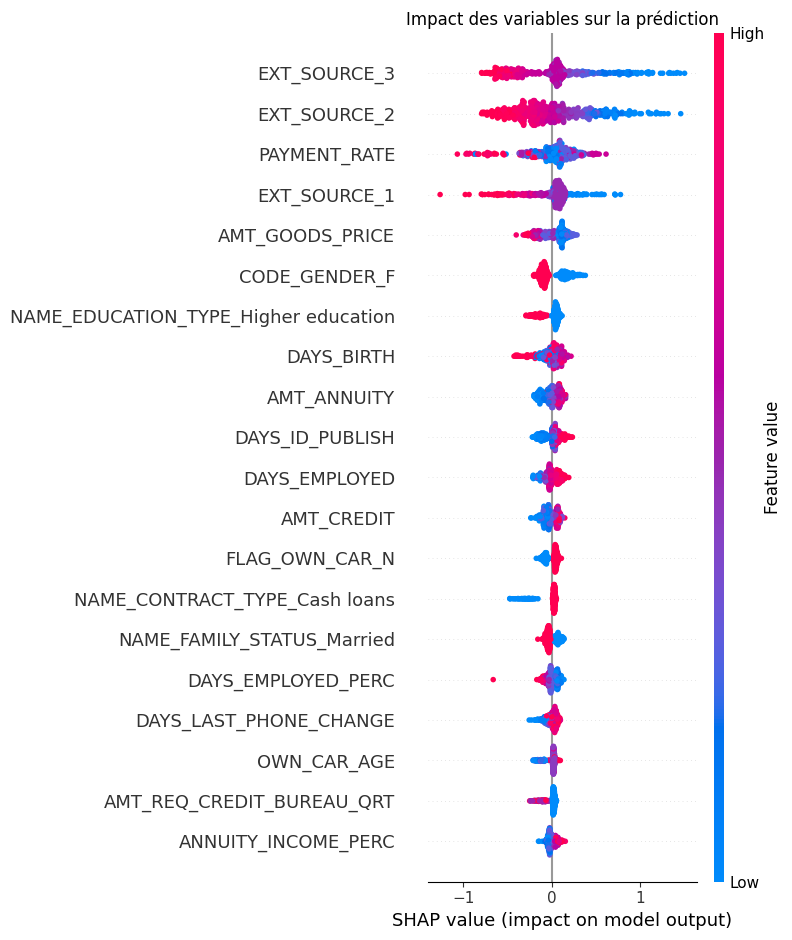

In [31]:
# ----------- Étape 1 : Accès au modèle et préparation de SHAP -----------
lgbm_model = final_lgbm_model.named_steps['classifier']
preprocessor = final_lgbm_model.named_steps['preprocessor']

# Créer un explainer SHAP pour le modèle
explainer = shap.TreeExplainer(lgbm_model)

# Calculer les valeurs SHAP pour le Summary Plot.
X_sample = X_train.sample(n=500, random_state=42)
X_sample_processed = preprocessor.transform(X_sample)

# Nettoyer les noms des colonnes pour un affichage plus clair
feature_names = preprocessor.get_feature_names_out()
feature_names_cleaned = [name.split('__')[-1] for name in feature_names]

# Convertir l'échantillon prétraité en DataFrame avec les noms de colonnes nettoyés
X_sample_processed = pd.DataFrame(X_sample_processed, columns=feature_names_cleaned, index=X_sample.index)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_sample_processed)

# ----------- Étape 2 : Création du SHAP Summary Plot (dot plot) -----------
print("--- Création du SHAP Summary Plot (dot plot) ---")
plt.figure(figsize=(10, 15))
shap.summary_plot(
    shap_values,
    X_sample_processed,
    plot_type="dot",
    show=False
)
plt.title("Impact des variables sur la prédiction")
plt.xlabel("SHAP value (impact on model output)")
plt.tight_layout()
plt.show()


Ce graphique nous permet de comprendre non seulement quelles variables sont importantes, mais aussi comment elles influencent la prédiction du modèle en fonction de leurs valeurs.  
Les features les plus importantes sont dans l'ordre, ext_source_3, ext_source_2, payment_rate, etc. La position horizontale d'un point indique l'impact de cette variable sur la prédiction de la classe 1 (le défaut de paiement)
Pour les 3 variables ext_source_3, ext_source_2, payment_rate, la majorité des points rouges se trouvent à gauche, ce qui signifie qu'une valeur élevée de cette variable diminue la probabilité de défaut de paiement

##### <a id='toc1_3_2_4_2_'></a>[Importance locale](#toc0_)

CLIENT AVEC ID 443433


L'ID client pour l'index 9 est : 443433

--- Analyse SHAP pour le client ID 443433 du jeu de validation (importance locale) ---


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


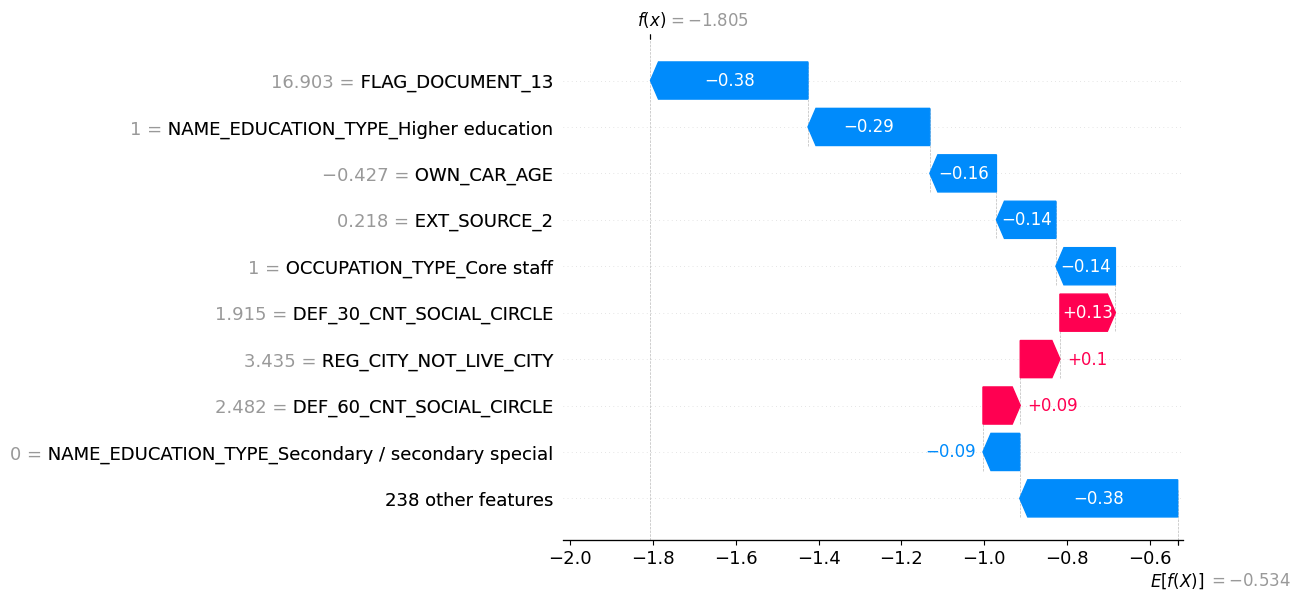

In [32]:
# --- Analyse SHAP pour un client spécifique du jeu de validation ---
X_val_with_id = train_df.loc[X_val.index].copy()

# Client 1
client_id_9 = X_val_with_id.iloc[9]['SK_ID_CURR']
print("\nL'ID client pour l'index 9 est :", client_id_9)
print("\n--- Analyse SHAP pour le client ID 443433 du jeu de validation (importance locale) ---")

X_sample_val = X_val.sample(n=500, random_state=42)
X_sample_val_processed = preprocessor.transform(X_sample_val)
X_sample_val_processed = pd.DataFrame(X_sample_val_processed, columns=feature_names_cleaned, index=X_sample_val.index)
shap_values_val = explainer.shap_values(X_sample_val_processed)

instance_to_explain_index_9 = 9
instance_to_explain_9 = X_sample_val_processed.iloc[instance_to_explain_index_9]

if isinstance(shap_values_val, list) and len(shap_values_val) > 1:
    shap_values_local_9 = shap_values_val[1][instance_to_explain_index_9]
    expected_value_local_9 = explainer.expected_value[1]
else:
    shap_values_local_9 = shap_values_val[instance_to_explain_index_9]
    expected_value_local_9 = explainer.expected_value

display(shap.force_plot(
    expected_value_local_9,
    shap_values_local_9,
    instance_to_explain_9
))

explanation_object_9 = shap.Explanation(
    values=shap_values_local_9,
    base_values=expected_value_local_9,
    data=instance_to_explain_9,
    feature_names=X_sample_val_processed.columns.tolist()
)

shap.waterfall_plot(explanation_object_9)
plt.show()

CLIENT AVEC ID 427037


L'ID client pour l'index 46 est : 427037

--- Analyse SHAP pour le client ID 427037 du jeu de validation (importance locale) ---


c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


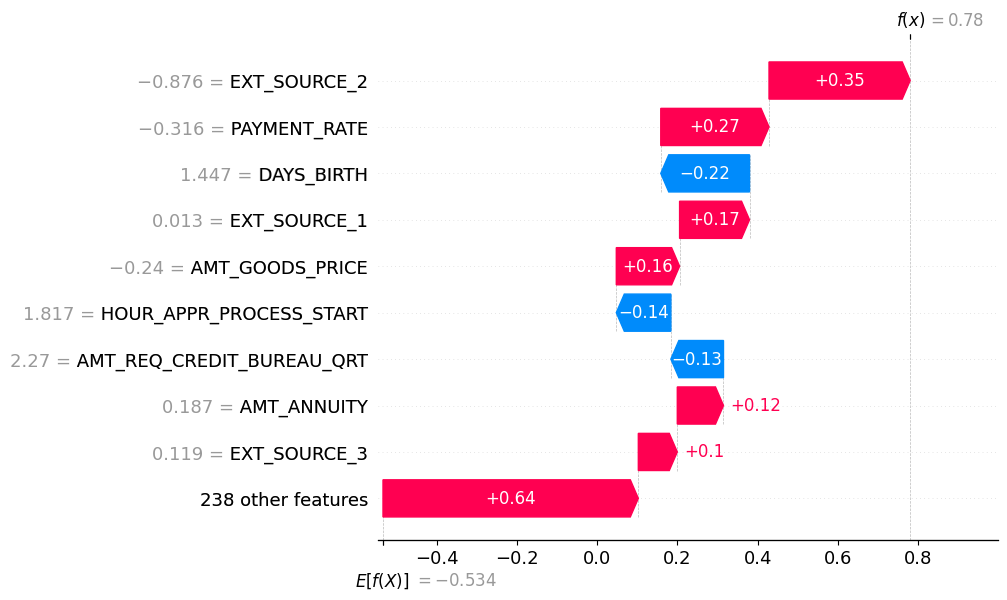

In [33]:
# Client 2
client_id_46 = X_val_with_id.iloc[46]['SK_ID_CURR']
print("\nL'ID client pour l'index 46 est :", client_id_46)
print("\n--- Analyse SHAP pour le client ID 427037 du jeu de validation (importance locale) ---")

X_sample_val_2 = X_val.sample(n=500, random_state=42)
X_sample_val_2_processed = preprocessor.transform(X_sample_val_2)
X_sample_val_2_processed = pd.DataFrame(X_sample_val_2_processed, columns=feature_names_cleaned, index=X_sample_val_2.index)
shap_values_val_2 = explainer.shap_values(X_sample_val_2_processed)

instance_to_explain_index_46 = 46
instance_to_explain_46 = X_sample_val_2_processed.iloc[instance_to_explain_index_46]

if isinstance(shap_values_val_2, list) and len(shap_values_val_2) > 1:
    shap_values_local_46 = shap_values_val_2[1][instance_to_explain_index_46]
    expected_value_local_46 = explainer.expected_value[1]
else:
    shap_values_local_46 = shap_values_val_2[instance_to_explain_index_46]
    expected_value_local_46 = explainer.expected_value

display(shap.force_plot(
    expected_value_local_46,
    shap_values_local_46,
    instance_to_explain_46
))

explanation_object_46 = shap.Explanation(
    values=shap_values_local_46,
    base_values=expected_value_local_46,
    data=instance_to_explain_46,
    feature_names=X_sample_val_2_processed.columns.tolist()
)

shap.waterfall_plot(explanation_object_46)
plt.show()

Ces graphiques sont des waterfalls plots de SHAP (SHapley Additive exPlanations), utilisés pour expliquer les prédictions individuelles d'un modèle de machine learning. Ils décomposent la contribution de chaque variable à la prédiction finale du modèle. Les Barres rouges représentent les caractéristiques qui augmentent la prédiction par rapport à la valeur de base. Les Barres bleues représentent les caractéristiques qui diminuent la prédiction.  

CLIENT AVEC ID 443433  
- FLAG_DOCUMENT_13 (16.903) a un impact très négatif (-0.38). Le fait que ce drapeau de document soit 1 indique une forte probabilité de défaut de paiement.
- NAME_EDUCATION_TYPE (Higher education) a un impact négatif significatif (-0.29), ce qui est contre-intuitif et pourrait révéler un biais dans les données 
- OWN_CAR_AGE (-0.427) a un impact négatif (-0.16). Une faible ancienneté de voiture (valeur négative) est associée à un risque de défaut.
- Autres caractéristiques : Les autres caractéristiques ont également un impact majoritairement négatif, confirmant la tendance de la prédiction finale.

CLIENT AVEC ID 427037
- EXT_SOURCE_2 (-0.876) a une forte contribution positive (+0.35). Une valeur faible pour cette caractéristique externe suggère que le client est fiable.
- PAYMENT_RATE (-0.316) a une forte contribution positive (+0.27), ce qui pourrait indiquer une faible charge de paiement et donc un client plus sûr.
- Autres caractéristiques : De nombreuses autres caractéristiques (238) ont collectivement un impact positif fort (+0.64) sur la prédiction finale.


### <a id='toc1_3_3_'></a>[Sauvegarde du modèle](#toc0_)

In [34]:
# Sauvegarde du modèle final (pipeline)
joblib.dump(final_lgbm_model, 'modele_de_scoring.pkl')

print("Le modèle final (pipeline) a été sauvegardé sous 'modele_de_scoring.pkl'")

Le modèle final (pipeline) a été sauvegardé sous 'modele_de_scoring.pkl'


### <a id='toc1_3_4_'></a>[Test et Sauvegarde pour tester l'API](#toc0_)

In [39]:
# 1. Sélectionner 20 clients à partir de l'original (pour la cohérence avec l'API)
# Le DataFrame original n'a pas les noms de colonnes nettoyés.
df_original = pd.read_csv('application_train.csv')

# Sélectionner 20 IDs aléatoires pour l'échantillon
sample_ids = df_original.sample(n=20, random_state=42)['SK_ID_CURR']

# Récupérer les lignes complètes pour ces IDs
raw_sample_clients = df_original[df_original['SK_ID_CURR'].isin(sample_ids)].copy()

# 2. Effectuer les prédictions dans le notebook
# Nettoyer les noms des colonnes pour les rendre compatibles avec la pipeline
cleaned_sample_clients = raw_sample_clients.copy()
cleaned_sample_clients.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in cleaned_sample_clients.columns]

# Utiliser la pipeline pour prédire sur ces données nettoyées
sample_proba_notebook = final_lgbm_model.predict_proba(cleaned_sample_clients)[:, 1]

# Classification avec le seuil optimal
sample_pred_notebook = (sample_proba_notebook >= best_threshold).astype(int)

print("\nRésultats de la prédiction dans le notebook:")
for i, row in results_notebook_df.iterrows():
    decision = "Refusé (risque de défaut élevé)" if row['Prediction_Optimal_Notebook'] == 1 else "Accepté (faible risque)"
    print(f"Client {int(row['SK_ID_CURR'])} → "
          f"Probabilité: {row['Probability_Notebook']:.4f}, "
          f"Décision: {decision}")
    

# 3. Préparer le fichier JSON pour l'API (avec noms de colonnes originaux)
# On retire les colonnes que l'API ne devrait pas recevoir
raw_sample_clients.drop(['TARGET'], axis=1, inplace=True)
raw_sample_clients.to_json('sample_clients_raw_data.json', orient='records', indent=4)
print("\nDonnées brutes de l'échantillon pour l'API sauvegardées dans 'sample_clients_raw_data.json'")


Résultats de la prédiction dans le notebook:
Client 119647 → Probabilité: 0.7196, Décision: Refusé (risque de défaut élevé)
Client 120952 → Probabilité: 0.7050, Décision: Refusé (risque de défaut élevé)
Client 134561 → Probabilité: 0.6391, Décision: Refusé (risque de défaut élevé)
Client 142232 → Probabilité: 0.7283, Décision: Refusé (risque de défaut élevé)
Client 180689 → Probabilité: 0.1806, Décision: Accepté (faible risque)
Client 188909 → Probabilité: 0.5790, Décision: Refusé (risque de défaut élevé)
Client 214010 → Probabilité: 0.1668, Décision: Accepté (faible risque)
Client 231383 → Probabilité: 0.0516, Décision: Accepté (faible risque)
Client 232220 → Probabilité: 0.3177, Décision: Accepté (faible risque)
Client 233043 → Probabilité: 0.4842, Décision: Accepté (faible risque)
Client 250804 → Probabilité: 0.5598, Décision: Refusé (risque de défaut élevé)
Client 257374 → Probabilité: 0.4583, Décision: Accepté (faible risque)
Client 283617 → Probabilité: 0.4713, Décision: Accepté

c:\Users\mon ordinateur\Desktop\Formation_openclassroom\projets\projet7\.venv\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Le fichier requirements
# %pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


## <a id='toc1_4_'></a>[Data Drift](#toc0_)

On détecte le data drift en comparant la distribution des données historiques (celles utilisées pour l'entraînement) avec celle des nouvelles données de production.

Il existe deux types principaux de dérive :

Drift de la cible (Concept Drift) : La relation entre les données d'entrée et la variable cible (ce que vous essayez de prédire) change. Par exemple, si l'impact du revenu sur le défaut de paiement d'un prêt évolue.

Drift des caractéristiques (Feature Drift) : La distribution des caractéristiques d'entrée change. Par exemple, si l'âge moyen des clients qui postulent pour un prêt augmente significativement par rapport aux données d'entraînement.

Des outils comme Evidently ou NannyML permettent d'automatiser cette détection en comparant les distributions statistiques des datasets.

Dans le but d'évaluer la stabilité de notre modèle, nous allons analyser la dérive des caractéristiques (feature drift) entre nos données d'entraînement et les données test. Cette analyse est cruciale car la performance d'un modèle de machine learning peut se dégrader si la distribution des données sur lesquelles il a été entraîné diffère de celle des données qu'il rencontre en production.

Pour ce faire, nous utiliserons la bibliothèque Evidently et son DataDriftPreset pour générer un rapport détaillé. Ce rapport comparera la distribution de chaque variable de notre jeu de données de référence (df_train) à celle de notre jeu de données actuel (df_test), identifiant ainsi les caractéristiques dont la distribution a significativement changé.

In [14]:
import pandas as pd
from utils import preprocess_data
from evidently import Report
from evidently.presets import DataDriftPreset  

# 1. Charger les datasets
df_train_raw = pd.read_csv("application_train.csv")
df_test_raw = pd.read_csv("application_test.csv")

# 2. Prétraitement
df_train = preprocess_data(df_train_raw)
df_test = preprocess_data(df_test_raw)

# 3. Construire le rapport avec le Preset de dérive des données
report = Report(
    metrics=[ DataDriftPreset() ]
)

# 4. Exécuter le rapport
result = report.run(reference_data=df_train, current_data=df_test)

# 5. Sauvegarder en html
result.save_html("data_drift_report.html")
print("✅ Rapport généré : data_drift_report.html")



✅ Rapport généré : data_drift_report.html


Le rapport indique que 8.73% des variables présentent une dérive significative. Ce pourcentage est inférieur au seuil de 10% généralement considéré comme un signal d'alarme critique pour la dégradation du modèle. Bien que le data drift soit bien présent, il n'est pas aussi généralisé